<a href="https://colab.research.google.com/github/hasanahaffendy/STQD6234-DataManagement/blob/main/Assignmnet4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1><strong>MongoDB </h1></strong>

<h1><strong>i) Calculate the average rating for each movie.  </h1></strong>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F

def parseRating(line):
    fields = line.split('\t')
    return Row(user_id=int(fields[0]), movie_id=int(fields[1]), rating=float(fields[2]), timestamp=int(fields[3]))

if __name__ == "__main__":
    # Create a SparkSession
    spark = SparkSession.builder.appName("MongoDBIntegration").getOrCreate()

    # Create the raw data
    lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.data")

    # Convert it to a RDD of Row objects with (userID, movieID, rating, timestamp)
    ratings = lines.map(parseRating)

    # Convert that to a DataFrame
    ratingsDataset = spark.createDataFrame(ratings)

    # Write it into MongoDB
    ratingsDataset.write \
        .format("com.mongodb.spark.sql.DefaultSource") \
        .option("uri", "mongodb://127.0.0.1/movielens.ratings") \
        .mode('append') \
        .save()

    # Read it back from MongoDB into a new DataFrame
    readRatings = spark.read \
        .format("com.mongodb.spark.sql.DefaultSource") \
        .option("uri", "mongodb://127.0.0.1/movielens.ratings") \
        .load()

    # Calculate the average rating for each movie
    avgRatings = readRatings.groupBy("movie_id").agg(F.avg("rating").alias("average_rating"))

    # Show the first 30 results in the order they appear
    avgRatings.orderBy("movie_id").limit(10).show(truncate=False)

    # Stop the session
    spark.stop()

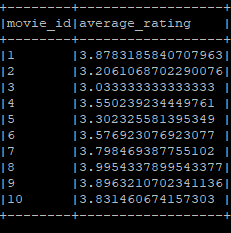

In [20]:
from IPython.display import Image

# Specify the path to your image file
image_path = '/content/drive/MyDrive/DataScience/q1.png'

# Display the image
Image(filename=image_path)

<h1><strong>ii) Identify the top ten movies with the highest average ratings.  </h1></strong>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

if __name__ == "__main__":
    # Create a SparkSession
    spark = SparkSession.builder.appName("TopMovies").getOrCreate()

    # Read the ratings data from MongoDB
    ratings = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
                      .option("uri", "mongodb://127.0.0.1/movielens.ratings") \
                      .load()

    # Calculate average rating per movie
    avgRatings = ratings.groupBy("movie_id") \
                        .agg(F.avg("rating").alias("average_rating"))

    # Find the top 10 movies with the highest average ratings
    topMovies = avgRatings.orderBy(F.desc("average_rating"), F.asc("movie_id")).limit(10)

    # Show the results
    topMovies.show(truncate=False)

    # Stop the Spark session
    spark.stop()

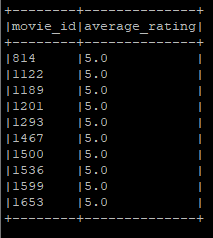

In [ ]:
from IPython.display import Image

# Specify the path to your image file
image_path = '/content/drive/MyDrive/DataScience/q2.png'

# Display the image with specified width and height
Image(filename=image_path)


<h1><strong>iii) Find the users who have rated at least 50 movies and identify their favourite movie genres. </h1></strong>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, array, posexplode, row_number, StringType
from pyspark.sql.window import Window

def find_active_users_and_favorite_genres(spark):
    # Load data from the u.data file
    ratings_df = spark.read \
        .format("csv") \
        .option("sep", "\t") \
        .option("header", False) \
        .option("inferSchema", True) \
        .load("hdfs:///user/maria_dev/ml-100k/u.data") \
        .toDF("user_id", "movie_id", "rating", "timestamp")

    # Load data from the u.item file
    movies_df = spark.read \
        .format("csv") \
        .option("sep", "|") \
        .option("header", False) \
        .option("inferSchema", True) \
        .load("hdfs:///user/maria_dev/ml-100k/u.item") \
        .toDF("movie_id", "movie_title", "release_date", "video_release_date", "imdb_url",
              "unknown", "Action", "Adventure", "Animation", "Childrens", "Comedy",
              "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
              "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western")

      # Calculate ratings count per user
    ratings_count_df = ratings_df.groupBy("user_id").count().withColumnRenamed("count", "ratings_count")

    # Filter users who rated at least 50 movies
    active_users_df = ratings_count_df.filter(col("ratings_count") >= 50)

    # Join ratings with movies
    ratings_movies_df = ratings_df.join(movies_df, "movie_id")

    # Explode genres and filter active users
    genre_cols = ["Action", "Adventure", "Animation", "Childrens", "Comedy",
                  "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
                  "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                  "Thriller", "War", "Western"]

    genre_expr = array([col(genre) for genre in genre_cols])
    exploded_genres_df = ratings_movies_df.select("user_id", "movie_id", posexplode(genre_expr)) \
        .withColumnRenamed("pos", "genre_idx") \
        .withColumnRenamed("col", "genre_ind")

    # Map genre index to genre name
    genre_mapping = dict(enumerate(genre_cols))
    genre_udf = spark.udf.register("genre_udf", lambda x: genre_mapping.get(x), StringType())

    exploded_genres_df = exploded_genres_df.filter(col("genre_ind") == 1) \
        .withColumn("genre", genre_udf(col("genre_idx")))

    # Count ratings per genre for each user
    user_genre_count_df = exploded_genres_df.groupBy("user_id", "genre").count()

    # Get the favorite genre for each user
    window_spec = Window.partitionBy("user_id").orderBy(col("count").desc())
    favorite_genres_df = user_genre_count_df.withColumn("rank", row_number().over(window_spec)) \
        .filter(col("rank") == 1) \
        .select("user_id", "genre") \
        .orderBy("user_id")  # Order by user_id

    return active_users_df.join(favorite_genres_df, "user_id").orderBy("user_id")

if __name__ == "__main__":
    # Create a SparkSession
    spark = SparkSession.builder \
        .appName("MovieLensAnalysis") \
        .getOrCreate()

    # Find active users and their favorite genres
    active_users_and_favorite_genres_df = find_active_users_and_favorite_genres(spark)

    # Show the results
    active_users_and_favorite_genres_df.show(10,truncate=False)

    # Stop the Spark session
    spark.stop()

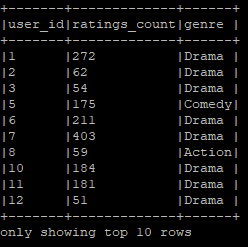

In [21]:
from IPython.display import Image

# Specify the path to your image file
image_path = '/content/drive/MyDrive/DataScience/q3.png'

# Display the image with specified width and height
Image(filename=image_path)


<h1><strong>Cassandra  </h1></strong>

<h1><strong>iv) Find all the users with age that is less than 20 years old.   </h1></strong>

In [22]:
from pyspark.sql import SparkSession

if __name__ == "__main__":
    # Create a SparkSession
    spark = SparkSession.builder \
        .appName("CassandraIntegration") \
        .config("spark.cassandra.connection.host", "127.0.0.1") \
        .getOrCreate()

    # Define Cassandra keyspace and table name
    KEYSPACE = "movielens"
    TABLE_NAME = "users"

    # Load data from Cassandra into a DataFrame
    readUsers = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table=TABLE_NAME, keyspace=KEYSPACE) \
        .load()

    # Create a temporary view for querying with SQL
    readUsers.createOrReplaceTempView("users")

    # Query to find users with age less than 20
    young_users = spark.sql("SELECT * FROM users WHERE age < 20 ORDER BY user_id")

    # Limit the results to 10 rows
    young_users_limit = young_users.limit(10)

    # Show the results
    young_users_limit.show()

    # Stop the SparkSession
    spark.stop()

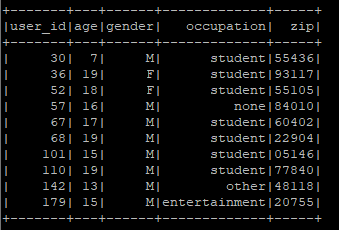

In [23]:
from IPython.display import Image

# Specify the path to your image file
image_path = '/content/drive/MyDrive/DataScience/q4.png'

# Display the image with specified width and height
Image(filename=image_path)


<h1><strong>Hbase  </h1></strong>

<h1><strong>v) Find all the users who have the occupation “scientist” and their age is between 30 and 40 years old.   </h1></strong>

In [ ]:
#Pig Script
users = LOAD '/user/maria_dev/ml-100k/u.user'
USING PigStorage('|')
AS (userID:int, age:int, gender:chararray, occupation:chararray, zip:int);

STORE users INTO 'hbase://users'
USING org.apache.pig.backend.hadoop.hbase.HBaseStorage(
'userinfo:age,userinfo:gender,userinfo:occupation,userinfo:zip');

In [ ]:
# Start HBase shell
hbase shell

# Scan the table 'userinfo' for users who are scientists and aged between 30 and 40
scan 'users', { FILTER => "(SingleColumnValueFilter('userinfo', 'occupation', =, 'binary:scientist') AND (SingleColumnValueFilter('userinfo', 'age', >=, 'binary:30') AND SingleColumnValueFilter('userinfo', 'age', <=, 'binary:40')))", LIMIT => 10 }


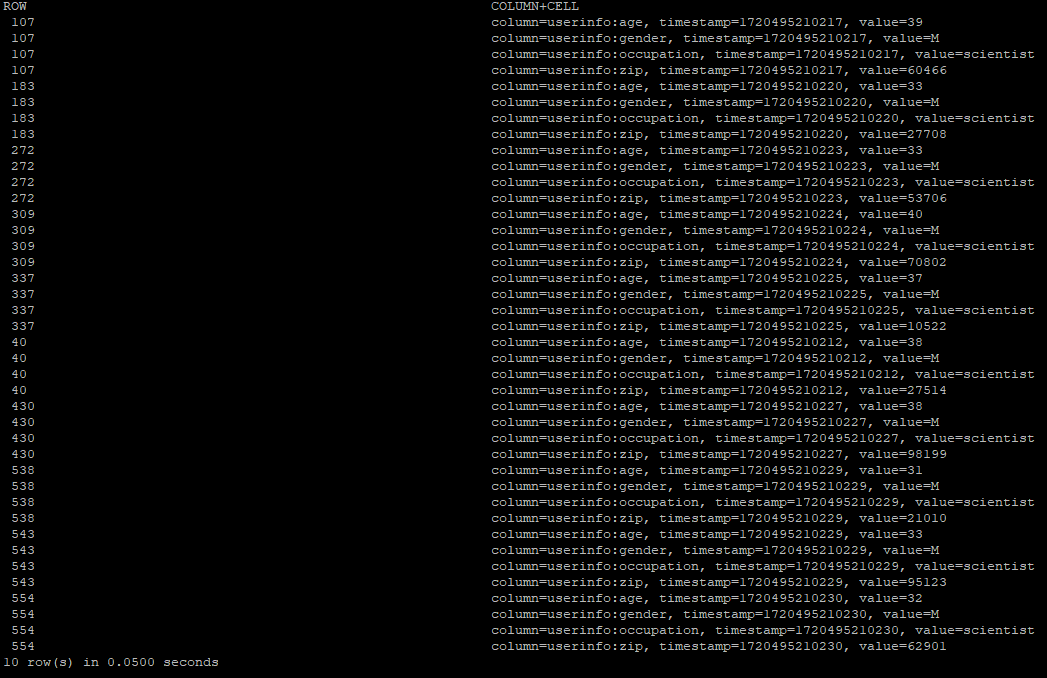

In [ ]:
from IPython.display import Image

# Specify the path to your image file
image_path = '/content/drive/MyDrive/DataScience/q5.1.png'

# Display the image with specified width and height
Image(filename=image_path)